# SMM4H 2026 Task 1 — Multilingual ADE Detection (EN/DE train, FR zero-shot)

This notebook implements the full exercise end-to-end in a **single file**:

- **Task 1.1**: Language selection (EN/DE train, FR eval-only), train/val/test splits (dev→test), preprocessing, EN→FR translation of **3000 EN train** samples stratified by label.
- **Task 1.2**: Multilingual exploration (label distribution, size differences, text length/type characteristics, manual inspection).
- **Task 1.3**: Modeling with the **same backbone** across setups (default: `xlm-roberta-base`):
  - Monolingual EN, monolingual DE
  - Multilingual EN+DE
  - Translation-trained (EN→FR translated train)
- **Task 1.4**: Evaluation (F1/precision/recall/accuracy, confusion matrices, per-language results) + cross-lingual error analysis.

## Model backbone swap (XLM-R → Microsoft multilingual model)
This notebook uses a single config variable `MODEL_NAME`. To switch to Microsoft’s multilingual model later:

- Change `MODEL_NAME = "xlm-roberta-base"` to:
  - `MODEL_NAME = "microsoft/mdeberta-v3-base"` (recommended)
  - or `MODEL_NAME = "microsoft/mdeberta-v3-large"` (heavier)

No other code changes should be required.


In [7]:
# Environment & reproducibility
import os
import re
import json
import math
import random
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd

import torch

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
)

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    set_seed,
)

import matplotlib.pyplot as plt
import seaborn as sns

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

auto_device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", auto_device)

ROOT = Path(".").resolve()
DATASET_DIR = ROOT / "dataset"
ARTIFACTS_DIR = ROOT / "artifacts"
ARTIFACTS_DIR.mkdir(exist_ok=True)

# Core experiment config
MODEL_NAME = "xlm-roberta-base"  # swap to "microsoft/mdeberta-v3-base" later
MAX_LENGTH = 256
VAL_FRACTION = 0.1
BATCH_SIZE = 16
EPOCHS = 2
LR = 2e-5
WEIGHT_DECAY = 0.01

TRAIN_LANGS = ["en", "de"]
ZERO_SHOT_LANG = "fr"

TRANSLATE_N = 3000
TRANSLATION_MODEL_NAME = "Helsinki-NLP/opus-mt-en-fr"  # offline MT via MarianMT

# If you need a quick smoke run, set this to True (uses smaller subsets)
DEBUG_SMALL = False

cfg = {
    "seed": SEED,
    "model_name": MODEL_NAME,
    "max_length": MAX_LENGTH,
    "val_fraction": VAL_FRACTION,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "lr": LR,
    "weight_decay": WEIGHT_DECAY,
    "train_langs": TRAIN_LANGS,
    "zero_shot_lang": ZERO_SHOT_LANG,
    "translate_n": TRANSLATE_N,
    "translation_model": TRANSLATION_MODEL_NAME,
}
print(json.dumps(cfg, indent=2))


torch: 2.9.1
cuda available: True
gpu: NVIDIA RTX 2000 Ada Generation Laptop GPU
device: cuda
{
  "seed": 42,
  "model_name": "xlm-roberta-base",
  "max_length": 256,
  "val_fraction": 0.1,
  "batch_size": 16,
  "epochs": 2,
  "lr": 2e-05,
  "weight_decay": 0.01,
  "train_langs": [
    "en",
    "de"
  ],
  "zero_shot_lang": "fr",
  "translate_n": 3000,
  "translation_model": "Helsinki-NLP/opus-mt-en-fr"
}


In [8]:
# Pandas/Jupyter display tweaks: wrap long text and allow horizontal scrolling
from IPython.display import HTML, display

# Prevent pandas from truncating long strings (e.g., the `text` column)
pd.set_option("display.max_colwidth", None)

# Make rendered DataFrame tables wrap text and scroll horizontally if needed
display(HTML("""
<style>
div.dataframe {
  overflow-x: auto;
}
div.dataframe table {
  width: 100%;
  table-layout: fixed;
}
div.dataframe td, div.dataframe th {
  vertical-align: top;
}
div.dataframe td {
  white-space: pre-wrap;
  word-break: break-word;
}
</style>
"""))

## Task 1.1 — Load CSVs (train) + redefine dev as test

We keep **French (fr)** as evaluation-only (zero-shot), and train only on **English (en)** and **German (de)**.

Preprocessing decisions (minimal, ADE-preserving):
- Normalize user mentions to `@USER`.
- Normalize URLs to `HTTPURL`.
- Normalize forum placeholder `<user>` to `@USER`.
- Do **not** lowercase (multilingual casing can matter).
- Keep punctuation/negations/dosage strings intact.
- TODO: What about emojis? For now, we keep them as-is (they can carry sentiment/ADE cues), but we could consider mapping them to text labels in future iterations.
- TODO: What about hashtags? Should we strip the `#` symbol? 



In [9]:
TRAIN_PATH = DATASET_DIR / "train_data_SMM4H_2026_Task_1.csv"
TEST_PATH = DATASET_DIR / "dev_data_SMM4H_2026_Task_1.csv"  # treated as TEST

assert TRAIN_PATH.exists(), f"Missing {TRAIN_PATH}"
assert TEST_PATH.exists(), f"Missing {TEST_PATH}"

train_raw = pd.read_csv(TRAIN_PATH)
test_raw = pd.read_csv(TEST_PATH)

print("train rows:", len(train_raw))
print("test rows:", len(test_raw))
print("columns:", list(train_raw.columns))


def _coerce_label(x) -> int:
    # labels are floats (0.0/1.0) in CSV
    if pd.isna(x):
        return 0
    return int(float(x))


USER_RE = re.compile(r"@USER_+")
HTTP_RE = re.compile(r"HTTPURL_+")
UNICODE_U4_RE = re.compile(r"\\u([0-9a-fA-F]{4})")
UNICODE_U8_RE = re.compile(r"\\U([0-9a-fA-F]{8})")


def _unescape_unicode(text: str) -> str:
    # Only unescape explicit unicode escape sequences like "\\u3000".
    text = UNICODE_U4_RE.sub(lambda m: chr(int(m.group(1), 16)), text)
    text = UNICODE_U8_RE.sub(lambda m: chr(int(m.group(1), 16)), text)
    return text


def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        text = "" if text is None else str(text)

    text = USER_RE.sub("@USER", text)
    text = HTTP_RE.sub("HTTPURL", text)

    # Forum placeholder
    text = text.replace("<user>", "@USER")

    # Some rows contain escaped unicode sequences like \u3000 (ideographic space)
    if "\\u" in text or "\\U" in text:
        text = _unescape_unicode(text)

    # Collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text


def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["label"] = out["label"].map(_coerce_label).astype(int)
    out["text"] = out["text"].map(normalize_text)
    out["language"] = out["language"].astype(str)
    out["type"] = out.get("type", "").astype(str)
    out["origin"] = out.get("origin", "").astype(str)
    return out


train_df = prepare_df(train_raw)
test_df = prepare_df(test_raw)

# Focus only on the requested languages
train_df = train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])].reset_index(drop=True)
test_df = test_df[test_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])].reset_index(drop=True)

print("train languages:")
print(train_df["language"].value_counts())
print("test languages:")
print(test_df["language"].value_counts())

print("train label distribution (overall):")
print(train_df["label"].value_counts(normalize=True))
print("test label distribution (overall):")
print(test_df["label"].value_counts(normalize=True))


train rows: 46737
test rows: 8033
columns: ['id', 'text', 'label', 'origin', 'type', 'language', 'split']
train languages:
language
en    17128
de     1482
fr      976
Name: count, dtype: int64
test languages:
language
en    888
de    634
fr    418
Name: count, dtype: int64
train label distribution (overall):
label
0    0.931022
1    0.068978
Name: proportion, dtype: float64
test label distribution (overall):
label
0    0.935052
1    0.064948
Name: proportion, dtype: float64


### Create validation split from train (stratified by language × label)

We train only on EN/DE, so validation is created from EN/DE **only** (French stays eval-only).

In [10]:
def make_val_split(
    df: pd.DataFrame,
    train_langs: List[str],
    val_fraction: float,
    seed: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    base = df[df["language"].isin(train_langs)].copy().reset_index(drop=True)
    strat = base["language"].astype(str) + "__" + base["label"].astype(str)

    splitter = StratifiedShuffleSplit(n_splits=1, test_size=val_fraction, random_state=seed)
    idx_train, idx_val = next(splitter.split(base, strat))

    train_part = base.iloc[idx_train].reset_index(drop=True)
    val_part = base.iloc[idx_val].reset_index(drop=True)
    return train_part, val_part

train_en_de, val_en_de = make_val_split(train_df, TRAIN_LANGS, VAL_FRACTION, SEED)

print("train_en_de:", len(train_en_de))
print("val_en_de:", len(val_en_de))

print("Train (EN/DE) distribution:")
print(train_en_de.groupby(["language", "label"]).size().unstack(fill_value=0))

print("Val (EN/DE) distribution:")
print(val_en_de.groupby(["language", "label"]).size().unstack(fill_value=0))

# Test is the provided dev file
print("Test distribution (EN/DE/FR):")
print(test_df.groupby(["language", "label"]).size().unstack(fill_value=0))


train_en_de: 16749
val_en_de: 1861
Train (EN/DE) distribution:
label         0     1
language             
de         1259    75
en        14337  1078
Val (EN/DE) distribution:
label        0    1
language           
de         140    8
en        1593  120
Test distribution (EN/DE/FR):
label       0   1
language         
de        599  35
en        827  61
fr        388  30


## Task 1.2 — Multilingual data exploration (EN / DE / FR)

This section produces quick exploratory summaries to understand:
- dataset size differences per language
- label imbalance per language
- platform/type mixture differences
- basic length distributions

Then we manually inspect examples across languages.


=== Train (filtered to EN/DE/FR) ===


,n,pos_rate,avg_words,p95_words
train_language,,,,
en,17128,0.069944,16.546707,27.00
de,1482,0.056005,100.806343,275.90
fr,976,0.071721,105.807377,313.25


=== Test (dev-as-test, filtered to EN/DE/FR) ===


,n,pos_rate,avg_words,p95_words
test_language,,,,
en,888,0.068694,16.247748,26.0
de,634,0.055205,100.746057,278.0
fr,418,0.071770,107.653110,295.6


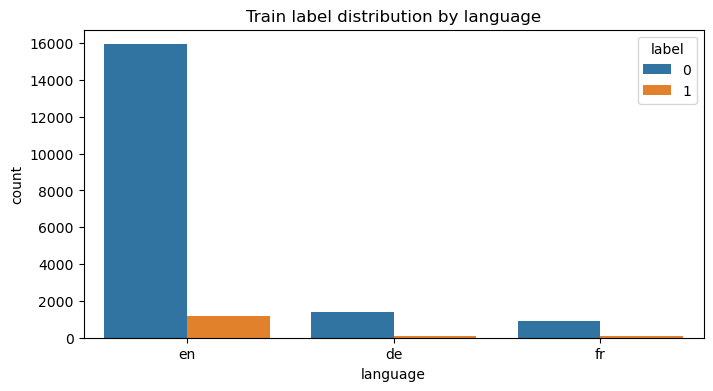

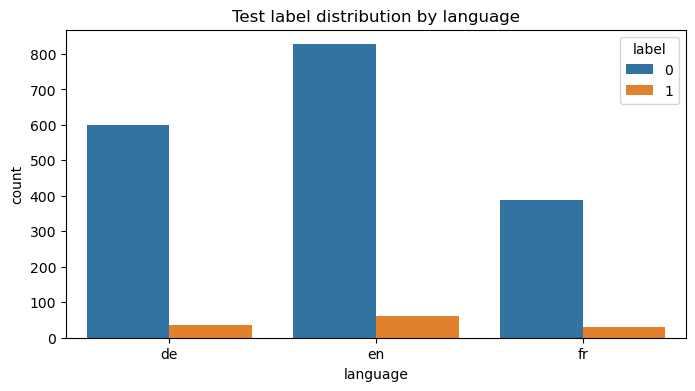

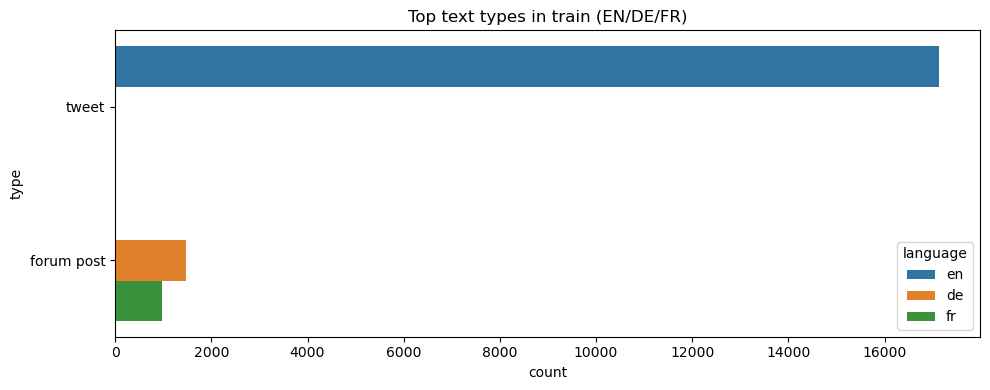

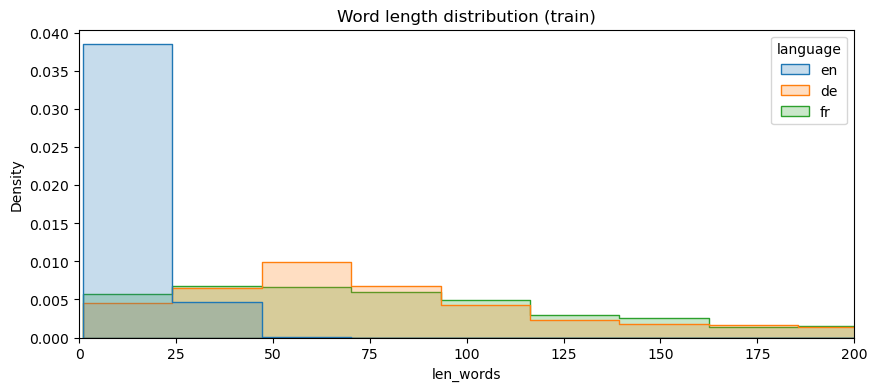

In [11]:
def describe_split(df: pd.DataFrame, name: str) -> pd.DataFrame:
    tmp = df.copy()
    tmp["len_chars"] = tmp["text"].astype(str).str.len()
    tmp["len_words"] = tmp["text"].astype(str).str.split().map(len)

    summary = (
        tmp.groupby("language")
        .agg(
            n=("id", "count"),
            pos_rate=("label", "mean"),
            avg_words=("len_words", "mean"),
            p95_words=("len_words", lambda s: float(np.percentile(s, 95))),
        )
        .sort_values("n", ascending=False)
    )
    summary.index.name = f"{name}_language"
    return summary

print("=== Train (filtered to EN/DE/FR) ===")
display(describe_split(train_df, "train"))

print("=== Test (dev-as-test, filtered to EN/DE/FR) ===")
display(describe_split(test_df, "test"))

# Label distribution plots
plt.figure(figsize=(8, 4))
sns.countplot(data=train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])], x="language", hue="label")
plt.title("Train label distribution by language")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=test_df, x="language", hue="label")
plt.title("Test label distribution by language")
plt.show()

# Type mix
plt.figure(figsize=(10, 4))
plot_df = train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])]
order = plot_df["type"].value_counts().head(8).index
sns.countplot(data=plot_df[plot_df["type"].isin(order)], y="type", hue="language")
plt.title("Top text types in train (EN/DE/FR)")
plt.tight_layout()
plt.show()

# Length distributions
plt.figure(figsize=(10, 4))
plot_df = train_df[train_df["language"].isin(TRAIN_LANGS + [ZERO_SHOT_LANG])].copy()
plot_df["len_words"] = plot_df["text"].astype(str).str.split().map(len)
sns.histplot(data=plot_df, x="len_words", hue="language", bins=60, element="step", stat="density", common_norm=False)
plt.xlim(0, 200)
plt.title("Word length distribution (train)")
plt.show()


### Manual inspection across languages

The following cell samples a few **positive** and **negative** examples per language for manual inspection.
Look for:
- negation and sarcasm
- dosage/medical abbreviations
- implicit adverse events vs explicit side effects
- annotation ambiguity


In [15]:
def sample_examples(df: pd.DataFrame, lang: str, label: int, n: int = 5, seed: int = 42) -> pd.DataFrame:
    sub = df[(df["language"] == lang) & (df["label"] == label)].copy()
    if len(sub) == 0:
        return sub
    return sub.sample(n=min(n, len(sub)), random_state=seed)[["id", "language", "label", "type", "origin", "text"]]

for lang in ["en", "de", "fr"]:
    print("\n=====", lang.upper(), "(NEG) =====")
    display(sample_examples(train_df, lang, 0, n=5, seed=SEED))
    print("\n=====", lang.upper(), "(POS) =====")
    display(sample_examples(train_df, lang, 1, n=5, seed=SEED))



===== EN (NEG) =====


,id,language,label,type,origin,text
7587,en_9488,en,0,tweet,previous_SMM4H,Can off label use of #Letrozole in #PCOS be recommended? HTTPURL
14727,en_9279,en,0,tweet,previous_SMM4H,@USER d: do you need a lozenge? or maybe drink lukewarm water?
2092,en_2109,en,0,tweet,previous_SMM4H,without boniva sally would be just a mumbling pile of shattered bone. #blessed #oscars
10820,en_1057,en,0,tweet,previous_SMM4H,"(This morning's cocktail of meds: 150mg pregabalin, 40mg fluoxetine, 50mg losartan, 500mg amoxicillin, multivitamin. It's fun!)"
11955,en_11378,en,0,tweet,previous_SMM4H,Fibro Question: Who has been on the Drug Merry-Go Round? (Vicodin to Lyrica to Elavil to Lunesta to Cymbalta to Lexipro on and on.)



===== EN (POS) =====


,id,language,label,type,origin,text
19270,en_16052,en,1,tweet,previous_SMM4H,#restlesslegs #quetiapine
16755,en_10231,en,1,tweet,previous_SMM4H,tysabri bruises are the best HTTPURL
1590,en_9952,en,1,tweet,previous_SMM4H,@USER i know. i just realised with everything else - i haven't taken the sodding quetiapine yet!! wondered why i wasn't drowsy doh!
7042,en_4786,en,1,tweet,previous_SMM4H,vyvanse makes my brain crazier than it already is.
897,en_1080,en,1,tweet,previous_SMM4H,slept 11 hours last night on seroquel o.o



===== DE (NEG) =====


,id,language,label,type,origin,text
8924,de_1272,de,0,forum post,LREC2022,"Hallo @USER Viel Frauen hier im Forum haben eine Chemo bekommen, aber ich hab noch nie davon gehört, dass man danach Impfungen auffrischen oder wiederholen muss. Ich bin fest der Meinung, dass die Ärzte einen darauf hinweisen würden........aber naja, am besten du fragst deinen Arzt danach. Ich hab zwe wirklich gute Ärzte, die mehr als nur die normalen Untersuchungen machen, aber keiner hat etwas dazu gesagt. Was man aber machen sollte, sich im Herbsz gegen die Grippe impfen lassen, da man nach eine Chemo noch sehr wenig Abwehrstoffe hat. Ich wünsch dir alles Gute, viel Glück und ein langes Leben @USER"
8233,de_885,de,0,forum post,LREC2022,"Liebe @USER danke für deinen Bericht. Das ist manchmal wirklich ein wochenweiser Wechsel. Erst warens die <Finger, jetzt die Knie. Mal sehen was morgen ist.... Ich wünsche >Dir nochen einen schönen Sonntag Lg @USER"
1494,de_656,de,0,forum post,LREC2022,"Hallo ihe Lieben, nachdem es mir ein Tage wirklich richig gut ging, kamen ein paar Tage voller Stress auf mich zu - Geburtstag des Sohnes, Streitereien familienintern weil, mein eigener Geburtstag und wieder ein Jahr älter hat ich innerlich so aufgewühlt, dass ich nachts wachwerde und erst nach einer Stunde lesen wieder einschlafen kann. Heute Morgen dann, an meinem Geburtstag versuchte ich zarte Fühler nach dem eigentlich doch schönen Tag auszustrecken, doch ließ die innere Unruhe nicht nach. Als ich im Badezimmer das Waschbecken putzte, überkam mich plötzlich ein Schwindel wie ich ihn so nicht kennengelernt hatte..es zog mir regelrecht vom Hinterkopf hoch und ich dachte echt, dass ich vornüber ins Wachbecken kippe. Prompt meldete sich meine Panik, mein Puls schnellte hoch, Blutdruck trotz Pille war auf 160/100 und ich dachte, dass ich an meinem Geburtstag dahingerafft werde. Bin dann sicherheitshalber zum Arzt, der meinte es läge an meinem inneren Stress, solche Familienfeste können sich krass aufs Gemüt legen so man nicht stabil und entspannt ist. Ich solle mich entspannen und gab mir Globuli gegen den Stress und die Angst. Nun gehts mir wieder besser, Blutdruck normal und auch kein Schwindel mehr, doch steckt mir der Schreck noch in den Gliedern. Wann hört das nur auf. Liegts an meiner Dünnhäutigkeit die durch die WJ verursacht werden oder ist da was Organisches? Warum haben so viele Frauen Schwindelzustände in den WJ, was genau geschieht dann? Haben gleich ne kleine Kaffeerunde und ich hoffe, dass ich das gut überstehen werde... so ein Mist..positiv denken ist manchmal garnicht so leicht. LG @USER"
6046,de_982,de,0,forum post,LREC2022,"Das hat mich erschreckt: Gestern auf Sat3 kamen zwei Sendungen: Gefährliche Umwelthormone und Im Takt der Hormone. Vielleicht hat es jemand geschaut? Leider kann man die Sendung im Internet nicht noch mal schauen. Vor allem ging es um die Hormonwirkung von Stoffen, die sich im Plastik befinden. Allem voran Bisphenol A. Diese Stoffe docken an Östrogenrezeptoren an und verändern die körpereigene Produktion. Es wurden zahlreiche wissenschaftliche Versuche gezeigt und erklärt. Bisphenol A und andere hormonähnliche Stoffe in Kunststoff werden mit vielen Krankheiten in Verbindung gebracht. Auch mit verfrühten WJ. Aber auch mit Fettleibigkeit, Diabetes, Allergien, ADHS, Autismus, Unfruchtbarkeit, verminderter Intelligenz...etc. pp. Für Kinder sind die Folgen richtig schlimm!!!! Ich verzichte ja schon geraume Zeit (möglichst) auf Nahrung und Getränke in Plastikverpackungen, benutze keine Tupperdosen, Frischhaltefolie etc. und ich denke, es wäre einen Versuch wert, diese hormonähnlichen Stoffe in der Ernährung zu minimieren. Aber auch Thermopapiere: Faxe, Kassenbons, Parkzettel....enthalten hohe Werte von Bisphenol A und sie gelangen durch Anfassen in den Körper..... Hier ein link: <url> Wenn man googelt, findet man viele weitere Infos. Ich wünsche allen geplagten Frauen hier ein schönes Wochenende. Habe Urlaub und werde ab Sonntag 8 Tage un


===== DE (POS) =====


,id,language,label,type,origin,text
6427,de_497,de,1,forum post,SMM4H_24_de_test,"Hallo, @USER! Dasselbe Problem hatte ich auch, bin richtig davon überrannt worden. Psychische Probleme kannte ich bis dato gar nicht. Das war auch mit ein Grund, die HET abzusetzen, weil ich zuletzt überhaupt nicht mehr damit klar kam. Ich denke heute, dass es einfach daran lag, dass mein Gyn mich mit Östrogen vollgepumpt hat, obgleich meine Progesteronwerte seit Jahren im Keller waren. Die Ö-Werte waren unter der HET in den letzten Jahren immer schön im grünen Bereich, die P-Werte aber gleich 0, somit lag eine fette Östrogendominanz vor! Das Gleichgewicht unter den Hormonen fehlte und hat dafür gesorgt, dass ich richtig, richtig Probleme bekommen habe. Bin ja jetzt erst mit der P-Creme angefangen, und gestern hatte ich mal wieder einen kleinen Rückschlag, aber ich bin guter Dinge, dass es eigentlich nur besser werden kann, wenn das P-Depot erst einmal wieder aufgebaut wurde. Bevor Du jetzt mit der P-Creme loslegst, würde ich aber auf jeden Fall empfehlen, erst einmal Deine Hormonwerte ermitteln zu lassen. Aber nachdem, was Du jetzt geschrieben hast, gehe ich davon aus, dass Dein P-Spiegel ebenfalls im Keller ist, weil der Körper einfach zum Zeitpunkt der Menopause kein P mehr produziert, aber Ö ist immer noch in geringen Mengen vorhanden. Also lass Dich nicht unterkriegen. Wenn Du vor der Menopause keine psychischen Probleme hattest, warum dann auf einmal? Ich werde auch derzeit von körperlichen Problemen regelrecht überfahren. Manchmal kenne ich mich selbst nicht mehr wieder. Herzrythmusstörungen, Depri etc. etc., das sind alles Sachen, worüber ich früher nur gelesen und leise geschmunzelt habe. Ich kann mich noch daran erinnern, dass wir in jungen Jahren über ältere Damen, die völlig durch den Wind waren, nur gelacht haben und immer kam der Spruch: 'Ach, die ist bestimmt in den WJ'! Also Kopf hoch, bisher haben es noch alle überlebt! LG @USER"
46,de_935,de,1,forum post,SMM4H_24_de_train,"Hallo @USER, du brauchst dich doch nicht zu entschuldigen. Ich habe 2015 ganz kurz Hormone probiert, aber das war in der Phase, in der ich selbst noch sehr verunsichert war ob meine Symptome wirklich von den Wechseljahren kommen. Hatte Gynokadin Gel und Famenita, war nicht so toll. Danach Tabletten, bekam nur Blutungen und Schmerzen. Jetzt werde ich ein Kombi Hormonpflaster ausprobieren. Werde dir berichten. Hatte mir geschworen, nur mit AD da durchzugehen, da ich von Frauen gelesen habe , die nach Absetzen der Hormone wieder richtig schlimme Symptome bekommen haben. Die Probleme wurden nur hinausgezögert. Da mir das AD momentan nicht so hilft ( hoffe es kommt noch die Erhöhung ist ja erst 2 Wochen her) werde ich die Hormone zumindest probieren. In der Apotheke meinten sie vielleicht verstoffwechsle ich schnell und daher hat die ganz niedrige Dosis AD nicht so angeschlagen. Mein Wirkspiegel ( habe das testen lassen) war nach 12 Wochen noch im unteren Bereich. Nein, wir haben noch keine Ferien. Noch eine Woche! Geht es dir heute besser? Bei mir la la. Wurschtle mich so durch. liebe Grüße @USER"
4628,de_1176,de,1,forum post,SMM4H_24_de_train,"Als ich damals mal Opri probiert habe, stand ich völlig neben mir. So richtig benebelt. . . . Wie durch Watte durch den Tag. . . Durch die Dämpfung fährt ja auch der Blutdruck bisschen runter und dann noch ein Senker obendrauf? Wäre für mich eine Erklärung, das du so neben der Spur bist. . . Wechselwirkungen? Sprich Bitte mit der Ärztin. . . .LG"
6522,de_1124,de,1,forum post,SMM4H_24_de_train,"Macht euch alle keine Sorgen, ich habe nur durch ziemliche Schmerzen zur Zeit, weil sich die Muskeln immer so verkrampfen und die Schmerztabletten und Valium hauen mir die Schuhe weg. Ich melde mich aber auf jeden Fall, ich habe ja nun eure E-Mail-Adressen. Bitte, mach dir keine Sorgen. Gruß @USER"
3559,de_117,de,1,forum post,SMM4H_24_de_train,"Hallo @USER, habe die Cerazette nur 4 Wochen genommen und nach 1 Woche ebenfalls 2 Tage lei


===== FR (NEG) =====


,id,language,label,type,origin,text
18789,fr_157,fr,0,forum post,LREC2022,"Je viens de voir que tu as répondu à ce message et que tu veux savoir comment cela se manifeste chez moi . ça a commencé dans le dos avec des petits boutons, je trouve que le soutien-gorge et le t-shirt sont laxistes sur la peau, ça frotte et ça me brûle. une fois que ça a disparu dans le dos, ça brûle sur la poitrine et maintenant c'est reparti !"
9386,fr_932,fr,0,forum post,LREC2022,"Salut @USER ,c'est vrai qu'avec les changements hormonaux ou les traitements hormonaux, on peut aussi avoir une sorte de mue vocale et la voix devient plus grave et plus rauque. prenons ça calmement Bises @USER"
7564,fr_397,fr,0,forum post,LREC2022,"Bonjour tabouret de bar, nous pouvons très volontiers ouvrir un fil CMD. Oui, j'ai aussi des douleurs articulaires et musculaires. En ce moment, c'est très dur. Je suis actuellement de nouveau en traitement de physiothérapie. Comme tout mon dos est raide comme une planche, de la colonne cervicale jusqu'à l'articulation ISG. D'après les analyses de sang, je n'ai pas de carence en œstrogènes. Les médecins ne te prennent vraiment plus au sérieux. Ouvre le guide sur les CMD et tu trouveras peut-être d'autres personnes qui partagent ton avis. Bises @USER"
15758,fr_728,fr,0,forum post,LREC2022,Souhaite à ta chère @USER un bon rétablissement. Bises
16857,fr_793,fr,0,forum post,LREC2022,"Salut, c'est vraiment ennuyeux. Maintenant, tu as pris des vacances supplémentaires, je ne pense pas qu'une semaine suffise pour récupérer. En particulier, tu fais raffermir ta poitrine et ton ventre, non ? J'ai d'ailleurs un rendez-vous vendredi après-midi. J'espère que ça va durer. En tout cas, je te souhaite bonne chance. J'espère que tu t'en sortiras bien. Salutations :-)"



===== FR (POS) =====


,id,language,label,type,origin,text
5559,fr_575,fr,1,forum post,SMM4H_24_fr_test,"Bonjour, j'ai commencé à utiliser Fumaderm il y a environ un an et demi. Le succès a été incroyable, mon psoriasis a complètement disparu. Entre-temps, la dermatologue m'a réduit à une dose d'un comprimé environ cinq jours sur sept de la semaine. Les effets secondaires ont été et restent très limités pour moi. Je n'ai pas du tout eu de maux d'estomac, ni de diarrhée significative. Seulement, les jours de prise, j'ai généralement une poussée de chaleur d'environ 20 minutes. C'est désagréable, mais sans commune mesure avec l'effet positif du produit. Mes valeurs sanguines se sont même améliorées au fil du temps. Salutations @USER."
175,fr_191,fr,1,forum post,SMM4H_24_fr_test,"Salut les amis, j'ai les yeux très secs depuis des années, puis le nez est venu s'ajouter et maintenant la bouche/le pharynx/les bronches aussi. Malheureusement, l'opipramol a aggravé la situation. C'est pourquoi j'ai acheté un gel hydratant (Aldiamed, flacon pulvérisateur) pour plus de 8 €. Je n'avais pas vraiment réalisé que l'ingrédient actif était un édulcorant - et je n'utilise pas d'édulcorants non plus. Maintenant, je sais pourquoi je ne le ferai pas à l'avenir : le gel était tellement sucré que j'étais complètement dégoûtée, la salive s'accumulait comme si on allait vomir. Malgré cela, la bouche était toujours sèche peu de temps après et une sensation rugueuse s'est ajoutée sur la langue (c'est également indiqué dans la notice). J'ai donc jeté le gel ... Maintenant, j'ai un petit vaporisateur en plastique vide pour 8 €... comme c'est gentil. Alors si l'une d'entre vous trouve quelque chose d'absolument neutre au niveau du goût, n'hésite pas à me le faire savoir. ( Ah oui - mon pharmacien a dit qu'il vaporisait aussi le spray nasal (sel d'Ems) dans sa bouche/gorge ... c'est ce que je fais maintenant avant de m'endormir). Amitiés @USER"
11676,fr_626,fr,1,forum post,SMM4H_24_fr_test,"Salut @USER Avec les suppositoires hormonaux, c'est très pratique ! On pense que si on les prend, on reste jeune et en forme ! Une erreur ! Ils passent immédiatement dans le sang et ont plusieurs effets secondaires. A cause des suppositoires, qui sont censées favoriser la circulation sanguine dans le vagin, j'ai pris beaucoup de poids (20 kilos de trop), j'ai eu beaucoup d'appetit, je n'avais plus d'énergie et mes yeux et mon visage étaient gonflés, comme si j'étais alcoolique. Sans oublier que j'avais aussi un gros myome. J'ai moi-même arrêté d'en prendre et maintenant je n'ai plus de myome, des yeux et un visage normaux et je suis comme toujours en forme, mince et pleine d'énergie. Utilise de l'huile d'amande bio !!!!! en cas de sécheresse vaginale. Mieux vaut donc ne pas la prendre ! Les gynécologues et les pharmacies font de grosses affaires et gagnent beaucoup d'argent avec ça. Les hormones pendant la ménopause NON, MERCI !"
674,fr_151,fr,1,forum post,SMM4H_24_fr_test,"Salut tout le monde, alors la protection de l'estomac m'intéresse aussi. Je prends de la sulfasalazine depuis quelques jours maintenant, je ne ressens qu'une fatigue extrême, mais pas de nausées jusqu'à présent, je dois juste faire des rots très souvent. Faut-il prendre un protecteur d'estomac ? On ne m'en a pas prescrit, on ne m'en a pas parlé non plus. Amitiés @USER"
14051,fr_293,fr,1,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai déjà pris quelques globules, car j'ai suivi un long traitement chez une naturopathe. Mes hormones sont toutes au plus bas, il reste encore un peu d'oestrogène (15) et je transpire plus, je suis en post-ménopause, c'est-à-dire que je n'ai pas eu de règles depuis plus de 3 ans. Mais je veux être satisfaite, c'était bien pire avant, je suis sûre que ça va s'arranger, c'est ce que ma gynécologue m'a dit l'autre jour. Je ne supporte pas les hormones chimiques et naturelles comme le Gynokadin et l'Utrogest, après tellement d'essais, juste pour info. Bonne soirée, salutations, @USER."



* Much smaller dataset size for DE and especially FR
* English samples have much fewer words on average than German and French (X vs forums)
* TODO: Address class imbalance:

1. Changes During Training (Algorithm-Level)
    - Weighted Loss Functions: Modify your loss function to penalize misclassifications of the minority class more heavily.
    - Class Weights: Assign a higher weight to the positive class in the Binary Cross Entropy loss.
    - Focal Loss: Use Focal Loss to down-weight "easy" majority examples and focus training on "hard" minority examples.
    - Threshold Moving: Instead of the default 0.5 probability threshold, lower the threshold for the positive class to increase recall.
    - Bias Initialization: Initialize the final layer's bias to 
 to prevent the model from spending initial epochs learning that the majority class is simply more frequent. 
2. Changes to Data (Data-Level)
    - Resampling:
        - Random Undersampling: Remove majority class examples to balance the ratio. While fast, it risks losing valuable information.
        - Random Oversampling: Duplicate minority examples. This is simple but can lead to overfitting.
    - Text Augmentation: Use NLP-specific techniques like Back-Translation (translating text to another language and back) or Synonym Replacement to create diverse new samples for the 0.5% minority class. 
3. Changes During Evaluation
    - Accuracy is misleading in this scenario (a model predicting "Negative" 100% of the time would achieve 99.5% accuracy). Instead, use: 
        - Precision-Recall (PR) Curve & AUPRC: Generally superior to ROC curves for extreme imbalance as it does not factor in True Negatives.
        - F1-Score. Use F1 to balance Precision and Recall, or F2 if missing a positive case (Recall) is more costly than a false alarm.
        - Confusion Matrix: Always inspect the raw counts of True Positives and False Negatives to understand the "cost" of the imbalance. 

## Task 1.1 (continued) — EN→FR translation (3000 EN samples, stratified by label)

We create a subset of **exactly 3000** English training examples, stratified by ADE label, translate them to French using an **offline MT model** (`Helsinki-NLP/opus-mt-en-fr`), and cache results to disk so reruns are fast.


In [14]:
from transformers import MarianMTModel, MarianTokenizer
from tqdm.auto import tqdm

TRANSLATIONS_CACHE = ARTIFACTS_DIR / f"translations_en_fr_{TRANSLATE_N}_seed{SEED}.csv"


def stratified_sample_en(df: pd.DataFrame, n: int, seed: int) -> pd.DataFrame:
    en = df[(df["language"] == "en")].copy().reset_index(drop=True)

    # If there aren't enough in one class, fall back to max possible while keeping stratification.
    counts = en["label"].value_counts().to_dict()
    n0 = counts.get(0, 0)
    n1 = counts.get(1, 0)

    target_0 = n // 2
    target_1 = n - target_0

    # Clamp to availability
    take_0 = min(target_0, n0)
    take_1 = min(target_1, n1)

    # If we couldn't reach n due to scarcity, fill from the other class
    remaining = n - (take_0 + take_1)
    if remaining > 0:
        if n0 - take_0 >= remaining:
            take_0 += remaining
        elif n1 - take_1 >= remaining:
            take_1 += remaining
        else:
            # Can't reach n at all
            take_0 = n0
            take_1 = n1

    part0 = en[en["label"] == 0].sample(n=take_0, random_state=seed) if take_0 > 0 else en.iloc[:0]
    part1 = en[en["label"] == 1].sample(n=take_1, random_state=seed) if take_1 > 0 else en.iloc[:0]

    out = pd.concat([part0, part1], axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out


def translate_en_to_fr(texts: List[str], model_name: str, batch_size: int = 16) -> List[str]:
    tok = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    outputs: List[str] = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Translating EN→FR"):
        batch = texts[i : i + batch_size]
        enc = tok(batch, return_tensors="pt", padding=True, truncation=True, max_length=MAX_LENGTH).to(device)
        with torch.no_grad():
            gen = model.generate(
                **enc,
                num_beams=4,
                max_new_tokens=MAX_LENGTH,
            )
        out = tok.batch_decode(gen, skip_special_tokens=True)
        outputs.extend(out)

    return outputs


def build_or_load_translations() -> pd.DataFrame:
    if TRANSLATIONS_CACHE.exists():
        print("Loading cached translations from:", TRANSLATIONS_CACHE)
        cached = pd.read_csv(TRANSLATIONS_CACHE)
        return cached

    en_subset = stratified_sample_en(train_en_de, n=TRANSLATE_N, seed=SEED)
    print("Sampled EN subset for translation:")
    display(en_subset["label"].value_counts())

    fr_texts = translate_en_to_fr(en_subset["text"].tolist(), model_name=TRANSLATION_MODEL_NAME, batch_size=16)

    out = en_subset.copy()
    out["text_en"] = out["text"]
    out["text"] = fr_texts
    out["language"] = "fr"
    out["translation_source"] = "en"
    out["translation_model"] = TRANSLATION_MODEL_NAME

    TRANSLATIONS_CACHE.parent.mkdir(exist_ok=True)
    out.to_csv(TRANSLATIONS_CACHE, index=False)
    print("Saved translations to:", TRANSLATIONS_CACHE)
    return out


fr_translated_train = build_or_load_translations()
print("Translated train rows:", len(fr_translated_train))
print(fr_translated_train[["language", "translation_source"]].drop_duplicates())

display(fr_translated_train[["label"]].value_counts())

# Show a small, balanced sample for manual inspection (EN original vs FR translation)
if "text_en" not in fr_translated_train.columns:
    print("Warning: 'text_en' column not found in translation cache; side-by-side view may be incomplete.")
    fr_translated_train = fr_translated_train.copy()
    fr_translated_train["text_en"] = ""

def _sample_translations_side_by_side(df: pd.DataFrame, label: int, n: int = 5, seed: int = 42) -> pd.DataFrame:
    sub = df[df["label"] == label].copy()
    if len(sub) == 0:
        return sub
    sub = sub.sample(n=min(n, len(sub)), random_state=seed)
    view_cols = [c for c in ["id", "label", "text_en", "text"] if c in sub.columns]
    view = sub[view_cols].rename(columns={"text_en": "EN", "text": "FR"})
    return view.reset_index(drop=True)

print("\nSample translations (5 NEG, 5 POS) — EN vs FR side-by-side")
display(_sample_translations_side_by_side(fr_translated_train, label=0, n=5, seed=SEED))
display(_sample_translations_side_by_side(fr_translated_train, label=1, n=5, seed=SEED))

Loading cached translations from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/translations_en_fr_3000_seed42.csv
Translated train rows: 3000
  language translation_source
0       fr                 en


label
0        1922
1        1078
Name: count, dtype: int64


Sample translations (5 NEG, 5 POS) — EN vs FR side-by-side


,id,label,EN,FR
0,en_308,0,"Made the perfect cocktail for tonight: Effexor, klonopin, minipress, abilify and a splash of diet coke. Yum!","Fait le cocktail parfait pour ce soir: Effexor, klonopin, minipress, abilfy et un jet de coke diététique. Miam!"
1,en_4740,0,"@USER @USER that's what imodium is for, get your bowel meds straight","@USER @USER C'est pour ça que l'imodium est là, redressez vos médocs intestinaux"
2,en_4320,0,"Cell Phones, Social Media, and the Problem of Identity ! You may think that your social media accounts are not too attractive. They are your new trend social #identity cards. Protect them. #cyber #CyberSecurity #informationsecurity #security #lostar20thyear @USER HTTPURL","Les téléphones cellulaires, les médias sociaux et le problème de l'identité ! Vous pouvez penser que vos comptes de médias sociaux ne sont pas trop attrayants. Ce sont vos nouvelles cartes sociales #identité tendance. Protégez-les. #cyber #CyberSecurity #informationsecurity #lostar20thyear @USER HTTPURL"
3,en_17941,0,"time for more levaquin (the ""nuke"" of antibiotics) #prostatitis","temps pour plus de levaquin (le ""nuke"" des antibiotiques) #prostatite"
4,en_7609,0,reminded about how lucky i am vs people with #cf being attached to just an albuterol inhaler the last two weeks. ugh.,On m'a rappelé à quel point je suis chanceux contre les gens avec #cf d'être attaché à un seul inhalateur d'albutérol au cours des deux dernières semaines.


,id,label,EN,FR
0,en_12212,1,i've had a trazodone headache all day. i heard they go away within a week. #hopeso #iactuallyslept,J'ai eu un mal de tête de trazodone toute la journée. J'ai entendu qu'ils s'en allaient dans une semaine. #hopeso #ifactallyslept
1,en_9127,1,@USER partly true but olanzapine is the worst ever for inducing carb cravings for some unfortunate ppl serequel and clozaril a 2nd,"@USER en partie vrai, mais l'olanzapine est le pire jamais pour induire des envies de glucides pour quelques malheureux ppl serequel et clozaril un 2ème"
2,en_16895,1,@USER zyprexa had me sleep walking!!!,@USER zyprexa m'a fait dormir en marchant!!!
3,en_975,1,people taking #quetiapine - does this need to sleep 24/7 go eventually? cos this is not sustainable beyond the short term.,Les personnes prenant #quetiapine - est-ce que ce besoin de dormir 24/7 va éventuellement? parce que ce n'est pas durable au-delà du court terme.
4,en_2075,1,fluoxetine makes me see shapes when i close my eyes,la fluoxétine me fait voir des formes quand je ferme les yeux


Translation analysis:
- Hashtags: Hashtags are often not translated. 

## Task 1.3 — Modeling (XLM-R classifier) + Task 1.4 — Evaluation and error analysis

We use the same training loop across setups via Hugging Face `Trainer`.

Setups:
1) **Monolingual EN**: train on EN only, evaluate on EN test
2) **Monolingual DE**: train on DE only, evaluate on DE test
3) **Multilingual EN+DE**: train on EN+DE, evaluate on EN test + DE test and **zero-shot FR test**
4) **Translation-trained FR**: train on EN→FR translated subset, evaluate on FR test

All setups share the same backbone via `MODEL_NAME`.


In [16]:
import gc
import inspect

def df_to_hf_dataset(df: pd.DataFrame) -> Dataset:
    cols = ["id", "text", "label", "language", "type", "origin"]
    cols = [c for c in cols if c in df.columns]
    return Dataset.from_pandas(df[cols], preserve_index=False)

def tokenize_dataset(ds: Dataset, tokenizer: AutoTokenizer, max_length: int) -> Dataset:
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, max_length=max_length)
    keep_cols = {"label", "language", "id", "type", "origin", "text"}
    drop_cols = [c for c in ds.column_names if c not in keep_cols]
    return ds.map(_tok, batched=True, remove_columns=drop_cols)

def compute_metrics(eval_pred):
    # HF may pass an EvalPrediction or a tuple depending on version
    if hasattr(eval_pred, "predictions") and hasattr(eval_pred, "label_ids"):
        logits = eval_pred.predictions
        labels = eval_pred.label_ids
    else:
        logits, labels = eval_pred


    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    preds = probs.argmax(axis=-1)


    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

def _ta_signature_params() -> Dict[str, inspect.Parameter]:
    return inspect.signature(TrainingArguments.__init__).parameters

def _training_args_kwargs(
    run_name: str,
    out_dir: Path,
    per_device_train_batch_size: int = BATCH_SIZE,
    per_device_eval_batch_size: int = BATCH_SIZE,
    gradient_accumulation_steps: int = 1,
    ) -> Dict:
    params = _ta_signature_params()
    kwargs = {
        "output_dir": str(out_dir),
        "run_name": run_name,
        "seed": SEED,
        "data_seed": SEED,
        "learning_rate": LR,
        "weight_decay": WEIGHT_DECAY,
        "per_device_train_batch_size": per_device_train_batch_size,
        "per_device_eval_batch_size": per_device_eval_batch_size,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "num_train_epochs": 1 if DEBUG_SMALL else EPOCHS,
        "load_best_model_at_end": True,
        "metric_for_best_model": "f1",
        "greater_is_better": True,
        "logging_steps": 50,
        "report_to": [],
        "fp16": torch.cuda.is_available(),
    }
    if "evaluation_strategy" in params:
        kwargs["evaluation_strategy"] = "epoch"
    else:
        kwargs["eval_strategy"] = "epoch"
    kwargs["save_strategy"] = "epoch"
    if "overwrite_output_dir" in params:
        kwargs["overwrite_output_dir"] = True
    if "gradient_accumulation_steps" not in params:
        kwargs.pop("gradient_accumulation_steps", None)
    return kwargs

def _inference_args(out_dir: Path) -> TrainingArguments:
    params = _ta_signature_params()
    kwargs: Dict = {
        "output_dir": str(out_dir),
        "per_device_eval_batch_size": BATCH_SIZE,
        "report_to": [],
    }
    # Ensure inference doesn't require eval_dataset and doesn't touch GPU
    if "evaluation_strategy" in params:
        kwargs["evaluation_strategy"] = "no"
    else:
        kwargs["eval_strategy"] = "no"
    kwargs["save_strategy"] = "no"
    if "no_cuda" in params:
        kwargs["no_cuda"] = True
    if "use_cpu" in params:
        kwargs["use_cpu"] = True
    return TrainingArguments(**kwargs)

def _free_cuda_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

def _is_oom_error(exc: BaseException) -> bool:
    name = exc.__class__.__name__.lower()
    msg = str(exc).lower()
    return "outofmemory" in name or "cuda out of memory" in msg or "out of memory" in msg

def train_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    run_name: str,
    model_name: str = MODEL_NAME,
    max_length: int = MAX_LENGTH,
    ) -> Tuple[Trainer, AutoTokenizer]:
    out_dir = ARTIFACTS_DIR / "runs" / run_name
    out_dir.mkdir(parents=True, exist_ok=True)
    best_dir = out_dir / "best_model"


    def _build_inference_trainer(tok: AutoTokenizer) -> Trainer:
        model = AutoModelForSequenceClassification.from_pretrained(str(best_dir))
        model.to("cpu")
        return Trainer(
            model=model,
            args=_inference_args(out_dir),
            data_collator=DataCollatorWithPadding(tokenizer=tok),
            compute_metrics=compute_metrics,
        )

    # If already trained, load and skip retraining (helps reruns + avoids OOM from repeated work)
    if best_dir.exists():
        tokenizer = AutoTokenizer.from_pretrained(str(best_dir), use_fast=True)
        _free_cuda_memory()
        print(f"Loaded existing model from: {best_dir}")
        return _build_inference_trainer(tokenizer), tokenizer


    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


    train_ds = tokenize_dataset(df_to_hf_dataset(train_df), tokenizer, max_length)
    val_ds = tokenize_dataset(df_to_hf_dataset(val_df), tokenizer, max_length)


    candidate_bs = [BATCH_SIZE, max(1, BATCH_SIZE // 2), max(1, BATCH_SIZE // 4)]
    candidate_bs = sorted(set(candidate_bs), reverse=True)


    last_exc: Optional[BaseException] = None
    for bs in candidate_bs:
        grad_acc = max(1, math.ceil(BATCH_SIZE / bs))
        _free_cuda_memory()


        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,
        )


        if torch.cuda.is_available():
            try:
                model.gradient_checkpointing_enable()
                if hasattr(model.config, "use_cache"):
                    model.config.use_cache = False
            except Exception:
                pass


        args = TrainingArguments(
            **_training_args_kwargs(
                run_name=run_name,
                out_dir=out_dir,
                per_device_train_batch_size=bs,
                per_device_eval_batch_size=bs,
                gradient_accumulation_steps=grad_acc,
            )
        )


        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
        )


        try:
            trainer.train()
            trainer.save_model(str(best_dir))
            tokenizer.save_pretrained(str(best_dir))


            # Drop training graph + optimizer state ASAP (critical for small GPUs)
            try:
                del trainer
                del model
            except Exception:
                pass
            _free_cuda_memory()


            if bs != BATCH_SIZE:
                print(f"Trained with reduced per-device batch size={bs} (grad_acc={grad_acc})")


            return _build_inference_trainer(tokenizer), tokenizer
        except BaseException as exc:
            last_exc = exc
            if _is_oom_error(exc):
                try:
                    del trainer
                    del model
                except Exception:
                    pass
                _free_cuda_memory()
                continue
            raise
    if last_exc is not None:
        raise last_exc
    raise RuntimeError("Training failed for unknown reasons")

def predict_proba(trainer: Trainer, tokenizer: AutoTokenizer, df: pd.DataFrame) -> np.ndarray:
    ds = tokenize_dataset(df_to_hf_dataset(df), tokenizer, MAX_LENGTH)
    preds = trainer.predict(ds)
    logits = preds.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    return probs

def evaluate_split(trainer: Trainer, tokenizer: AutoTokenizer, df: pd.DataFrame, lang: str, name: str) -> Dict:
    sub = df[df["language"] == lang].copy().reset_index(drop=True)
    if len(sub) == 0:
        return {"name": name, "lang": lang, "n": 0}


    probs = predict_proba(trainer, tokenizer, sub)
    pred = probs.argmax(axis=-1)
    y = sub["label"].values


    precision, recall, f1, _ = precision_recall_fscore_support(y, pred, average="binary", zero_division=0)
    acc = accuracy_score(y, pred)
    cm = confusion_matrix(y, pred)


    return {
        "name": name,
        "lang": lang,
        "n": len(sub),
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
        "_df": sub,
        "_probs": probs,
        "_pred": pred,
    }

def show_confusion(cm: np.ndarray, title: str):
    plt.figure(figsize=(3.5, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Pred")
    plt.ylabel("Gold")
    plt.show()

### Train: Monolingual EN and DE

Training uses `train_en_de` / `val_en_de` but filtered per-language.


In [20]:
def filter_lang(df: pd.DataFrame, lang: str) -> pd.DataFrame:
    return df[df["language"] == lang].copy().reset_index(drop=True)

# Optionally shrink for debugging
if DEBUG_SMALL:
    train_en = filter_lang(train_en_de, "en").sample(n=min(800, len(filter_lang(train_en_de, "en"))), random_state=SEED)
    val_en = filter_lang(val_en_de, "en").sample(n=min(200, len(filter_lang(val_en_de, "en"))), random_state=SEED)
    train_de = filter_lang(train_en_de, "de").sample(n=min(800, len(filter_lang(train_en_de, "de"))), random_state=SEED)
    val_de = filter_lang(val_en_de, "de").sample(n=min(200, len(filter_lang(val_en_de, "de"))), random_state=SEED)
else:
    train_en = filter_lang(train_en_de, "en")
    val_en = filter_lang(val_en_de, "en")
    train_de = filter_lang(train_en_de, "de")
    val_de = filter_lang(val_en_de, "de")

print("EN train/val:", len(train_en), len(val_en))
print("DE train/val:", len(train_de), len(val_de))

trainer_en, tok_en = train_model(train_en, val_en, run_name="monolingual_en")
trainer_de, tok_de = train_model(train_de, val_de, run_name="monolingual_de")


EN train/val: 15415 1713
DE train/val: 1334 148
Loaded existing model from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/monolingual_en/best_model


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1742.38it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


Loaded existing model from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/monolingual_de/best_model


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1849.49it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


### Train: Multilingual EN+DE

Train on EN+DE jointly, validate on EN+DE joint validation.


In [17]:
if DEBUG_SMALL:
    train_multi = train_en_de.sample(n=min(1600, len(train_en_de)), random_state=SEED)
    val_multi = val_en_de.sample(n=min(400, len(val_en_de)), random_state=SEED)
else:
    train_multi = train_en_de
    val_multi = val_en_de

print("Multilingual train/val:", len(train_multi), len(val_multi))

trainer_multi, tok_multi = train_model(train_multi, val_multi, run_name="multilingual_en_de")


Multilingual train/val: 16749 1861
Loaded existing model from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/multilingual_en_de/best_model


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1914.95it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


### Train: Translation-trained FR (EN→FR translated train)

Train a classifier on the translated French training subset and evaluate on **native French test**.


In [18]:
# Split translated FR train into train/val (stratified by label)
fr_strat = fr_translated_train["label"].astype(str)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
idx_tr, idx_va = next(splitter.split(fr_translated_train, fr_strat))
fr_train = fr_translated_train.iloc[idx_tr].reset_index(drop=True)
fr_val = fr_translated_train.iloc[idx_va].reset_index(drop=True)

if DEBUG_SMALL:
    fr_train = fr_train.sample(n=min(800, len(fr_train)), random_state=SEED)
    fr_val = fr_val.sample(n=min(200, len(fr_val)), random_state=SEED)

print("FR translated train/val:", len(fr_train), len(fr_val))

trainer_fr_trans, tok_fr_trans = train_model(fr_train, fr_val, run_name="translation_trained_fr")


FR translated train/val: 2700 300
Loaded existing model from: /home/mandado/repos/advanced nlp/smm4h2026/artifacts/runs/translation_trained_fr/best_model


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 1760.26it/s, Materializing param=roberta.encoder.layer.11.output.dense.weight]              


### Evaluate all setups (per language)

We report metrics on the dev-as-test set for EN/DE/FR.


Map: 100%|██████████| 888/888 [00:00<00:00, 33537.21 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 10527.13 examples/s]


Map: 100%|██████████| 634/634 [00:00<00:00, 18038.06 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 16375.58 examples/s]


Map: 100%|██████████| 888/888 [00:00<00:00, 63582.61 examples/s]


Map: 100%|██████████| 634/634 [00:00<00:00, 17222.50 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 14925.46 examples/s]


Map: 100%|██████████| 418/418 [00:00<00:00, 14439.65 examples/s]


,name,lang,n,accuracy,precision,recall,f1
5,multi_en_de,de,634,0.946372,1.000000,0.028571,0.055556
2,mono_de,de,634,0.944795,0.000000,0.000000,0.000000
0,mono_en,en,888,0.942568,0.580645,0.590164,0.585366
4,multi_en_de,en,888,0.940315,0.574074,0.508197,0.539130
7,translation_trained_fr,fr,418,0.540670,0.125000,0.900000,0.219512
6,multi_en_de,fr,418,0.868421,0.096774,0.100000,0.098361
1,mono_en_zero_shot_fr,fr,418,0.906699,0.000000,0.000000,0.000000
3,mono_de_zero_shot_fr,fr,418,0.928230,0.000000,0.000000,0.000000


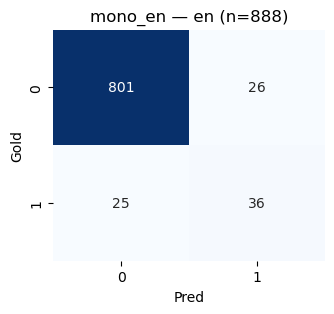

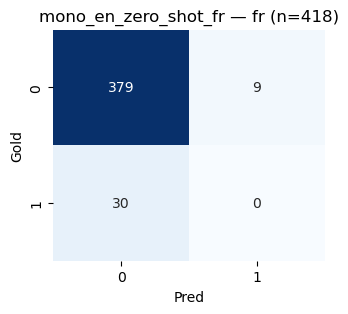

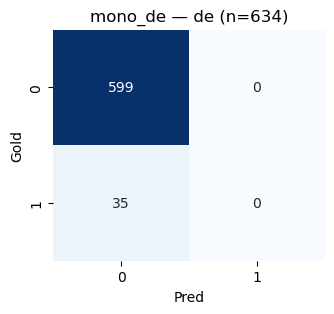

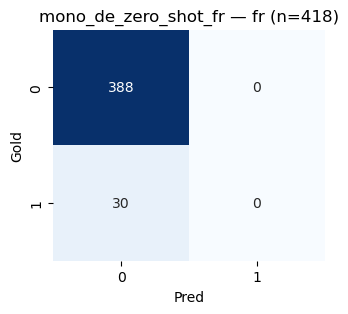

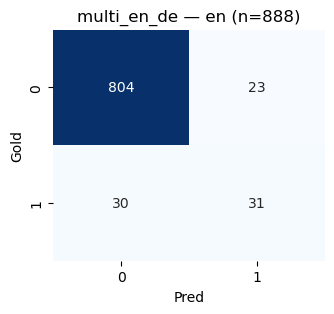

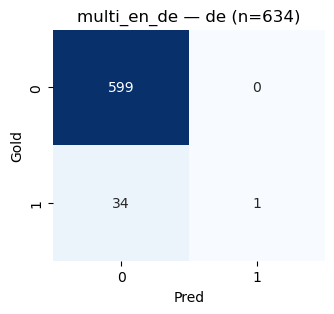

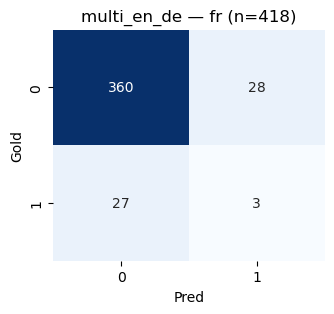

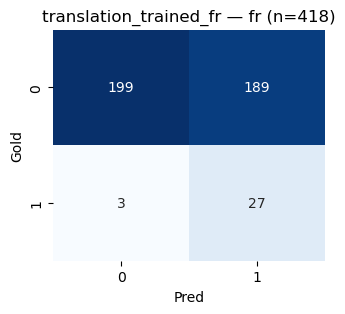

In [21]:
results: List[Dict] = []

# Monolingual EN: evaluate EN test and also check zero-shot FR
results.append(evaluate_split(trainer_en, tok_en, test_df, "en", name="mono_en"))
results.append(evaluate_split(trainer_en, tok_en, test_df, "fr", name="mono_en_zero_shot_fr"))

# Monolingual DE
results.append(evaluate_split(trainer_de, tok_de, test_df, "de", name="mono_de"))
results.append(evaluate_split(trainer_de, tok_de, test_df, "fr", name="mono_de_zero_shot_fr"))

# Multilingual EN+DE
for lang in ["en", "de", "fr"]:
    results.append(evaluate_split(trainer_multi, tok_multi, test_df, lang, name="multi_en_de"))

# Translation-trained FR
results.append(evaluate_split(trainer_fr_trans, tok_fr_trans, test_df, "fr", name="translation_trained_fr"))

# Tabulate
rows = []
for r in results:
    if r.get("n", 0) == 0:
        continue
    rows.append({k: r[k] for k in ["name", "lang", "n", "accuracy", "precision", "recall", "f1"]})

metrics_df = pd.DataFrame(rows).sort_values(["lang", "f1"], ascending=[True, False])
display(metrics_df)

# Show confusion matrices
for r in results:
    if r.get("n", 0) == 0 or "confusion_matrix" not in r:
        continue
    show_confusion(r["confusion_matrix"], title=f"{r['name']} — {r['lang']} (n={r['n']})")


### Error analysis (cross-lingual)

We inspect false positives/negatives per language and compare FR failures between:
- multilingual zero-shot
- translation-trained FR

This helps identify:
- language-specific patterns (negation, colloquialisms)
- translation artifacts
- robustness differences across training setups


In [22]:
def error_table(result: Dict, top_k: int = 10) -> pd.DataFrame:
    df = result["_df"].copy()
    probs = result["_probs"]
    pred = result["_pred"]

    df["pred"] = pred
    df["p_pos"] = probs[:, 1]
    df["is_error"] = df["pred"] != df["label"]

    # Sort errors by confidence
    err = df[df["is_error"]].copy()
    err["conf"] = np.where(err["pred"] == 1, err["p_pos"], 1 - err["p_pos"])
    err = err.sort_values("conf", ascending=False)

    keep_cols = [c for c in ["id", "language", "label", "pred", "p_pos", "type", "origin", "text"] if c in err.columns]
    return err[keep_cols].head(top_k)

# Collect named results for convenient lookup
res_map = {(r.get("name"), r.get("lang")): r for r in results if r.get("n", 0) > 0 and "_df" in r}

for lang in ["en", "de", "fr"]:
    key = ("multi_en_de", lang)
    if key in res_map:
        print(f"\nTop errors for multilingual on {lang.upper()}")
        display(error_table(res_map[key], top_k=8))

# Compare FR: multilingual zero-shot vs translation-trained
fr_zero = res_map.get(("multi_en_de", "fr"))
fr_trans = res_map.get(("translation_trained_fr", "fr"))

if fr_zero and fr_trans:
    print("\nFR errors — multilingual zero-shot")
    display(error_table(fr_zero, top_k=8))

    print("\nFR errors — translation-trained")
    display(error_table(fr_trans, top_k=8))



Top errors for multilingual on EN


,id,language,label,pred,p_pos,type,origin,text
251,en_815,en,1,0,0.001025,tweet,previous_SMM4H,"@USER I've had Cipro before. Luckily for me, the only side fx I tend to get from AB is gastic upset. But I RARELY use AB."
763,en_441,en,1,0,0.003253,tweet,previous_SMM4H,rt @USER: @USER i cannot be in the sun! #levaquin
202,en_214,en,1,0,0.003472,tweet,previous_SMM4H,debating on taking a trazodone and literally passing out for the day.
853,en_351,en,0,1,0.991679,tweet,previous_SMM4H,Oh darn! i havent woke up in this much pain in a while...right back 2 bed i go #crohns #ibd #humira
742,en_177,en,0,1,0.989673,tweet,previous_SMM4H,It's been about 2 weeks since I cold-turkey quit taking 100mg desvenlafaxine every day for the past year. Didn't have any withdrawal
872,en_723,en,0,1,0.989033,tweet,previous_SMM4H,think im gonna have to start taking my vyvanse again. my lack of motivation to do anything is scary
220,en_11,en,0,1,0.988720,tweet,previous_SMM4H,after 3 1/2 hours of sleep i'm exhausted but can't fall asleep ??... this trazodone is gonna knock me out ????
307,en_618,en,0,1,0.988041,tweet,previous_SMM4H,vyvanse makes me happy. i kinda like finals week. #drugaddict #unlimitedfocus



Top errors for multilingual on DE


,id,language,label,pred,p_pos,type,origin,text
498,de_564,de,1,0,0.001423,forum post,SMM4H_24_de_dev,"War dir nicht schlecht von Reparil? Mir war dauernd übel davon, habe es deswegen auch nicht durchziehen können... Übrigens, bist du nicht der @USER der eine OP bei <doc> hatte? Ich glaube wir haben irgendwann vor Monaten hier diskutiert! Falls ja, wie ist es gelaufen? Liebe Grüsse @USER"
260,de_119,de,1,0,0.002680,forum post,SMM4H_24_de_dev,"Liebe @USER, ich würde an deiner Stelle nochmal mit meiner FA sprechen. Es gibt so viele Möglichkeiten der Hormontherapie, da ist das Pflaster nur eine von vielen. Meine FA fragte mich immer, ob ich zufrieden sei und man könne jederzeit auf ein anderes Präparat wechseln. Ich habe erst Cliogest genommen und dann wegen vermehrten Haarwuchs im Gesicht gewechselt auf Lafamme. Damit kam ich dann gut zurecht. liebe Grüße @USER"
406,de_285,de,1,0,0.009711,forum post,SMM4H_24_de_dev,"Hallo @USER, Hallo @USER - also ich nehme Agnucaston und die Traubensilberkerze - mein Frauenarzt hat zwar auch gedacht, Agnucaston nutzt nichts mehr, da ich meine Periode seit 1 Jahr nicht mehr habe. Aber ich habe es davor immer genommen - schon seit 1998, da es mir sehr gut gegen Eierstockzysten geholfen hat. Auch 2006 hatte ich am Rechten Eierstock eine Zyste, auf der sich ein komischer Bereich gebildet hatte - Der Frauenarzt meinte schon - in 4 Wochen sehen wir weiter, wenn dass alles noch da ist, dann kommt der Eierstock raus (den brauchen Sie ja eh nicht mehr...!!!). ich habe daraufhin den Arzt gewechselt - wieder mit Agnucaston angefangen, Schüsslersalze Kalium chloratum und Natrium Chloratum genommen - bei den Kontrolluntersuchungen in den nächsten 6 Monaten war die Zyste weg! - Derzeit habe ich zwar wieder eine ganz kleine, aber der FA meint - ist in Ordnung - und der Eierstock ist noch drin!! - Dies ist nun mein Grund warum ich Agnucaston nehme - Es wirkt auch gut gegen Zysten in der Brust, wenn man dazu neigt. Zunehmen tue ich leider auch, ob das von der Traubensilberkerze auch noch verstärkt wird weiß ich nicht - mein FA sagt nein --- aber ich bin mir auch unsicher. Ich darf übrigens auch keine Hormone nehmen, hatte mit 29 Jahren von der Pille einen Hirnarterienverschluss. Die üblichen Beschwerden wie alle habe ich leider auch - ganz schlimm ist zur Zeit Herz/Kreislauf - kein Tag ohne Beschwerden!! Liebe Grüsse an Euch! Schreibt mal wieder @USER"
333,de_359,de,1,0,0.009855,forum post,SMM4H_24_de_train,Guten Morgen ... so die erste FamentinaKapsel habe ich genommen ... was soll ich sagen ... ich habe einen Magen wie wenn viel Luft drin wäre ... und vom Kopf her entwas komisch und Unruhe hab ich auch ... geschlafen hab ich vorher fast besser ... hm ... ist das erst eine Eingewöhnung ... ???
89,de_450,de,1,0,0.009919,forum post,SMM4H_24_de_test,"Hallo <doc>,ich mache keine systemischer Hormontherapie. Ich habe bisher Estriol nur lokal angewandt.es geht auch nicht um Beschwerden beim Verkehr,sondern um die Behandlung einer atrophischen Vaginitis mit den Symptomen Brennen und Schmerzen in der Scheide,so dass sogar das Gehen und Sitzen schon Schmerzen. Es fühlt sich raus und trocken an wie Schmirgelpapier. Leider haben alle bisherigen Maßnahmen die Symptome verschlechtert. LG @USER"
126,de_197,de,1,0,0.010581,forum post,SMM4H_24_de_train,"Hab das climavita forte grad mal gegooglt: ist ja Traubensilberkerze 13 mg. Meins (femikliman uno) enthält 6,5 mg. Bin seit der 4. Woche der Einnahme stimmungsstabiler u. etwas ruhiger. Unterstütze noch mit dem @USER plantina. Nebenwirkungen sind bei mir etwas Gewichtszunahme (~2kg). LG @USER"
47,de_169,de,1,0,0.015585,forum post,SMM4H_24_de_train,Lieben Dank für die schnelle Antwort. Nein nehme keine weiteren Medikamente bzgl Hormone jedoch opipramol... Antidepressiva Vor einem Jahr habe ich einen Tag Östrogen Gel genommen doch die Angst vor Nebenwirkungen hat gesiegt. Die Lust auf Sex ist einfach komplett weg. Wie wenn ich geschlechtslos wäre.. das macht mich fertig...Fühle m


Top errors for multilingual on FR


,id,language,label,pred,p_pos,type,origin,text
365,fr_364,fr,1,0,0.007165,forum post,SMM4H_24_fr_test,"Ah oui, peut-être intéressant pour certains. Dans mon désespoir, j'ai aussi essayé un AD. Chez moi, la TSH est montée en flèche ! Le psychiatre n'en avait jamais entendu parler... c'est vraiment fou. D'ailleurs, ça n'a pas du tout aidé. Heureusement, j'ai pu l'arrêter sans problème."
231,fr_17,fr,0,1,0.984353,forum post,LREC2022,"J'ai eu ça récemment aussi, des palpitations cardiaques et c'est tellement dégoûtant. Cela a duré deux jours et ensuite, le calme est revenu pendant des semaines. J'ai 57 ans et je pense que tout doit revenir à la normale."
266,fr_415,fr,1,0,0.017481,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai aussi des crises de transpiration, c'est en partie à cause des médicaments ( MTX et Corti ). Ma thyroïde y contribue aussi, je suis en hypothyroïdie. As-tu déjà fait examiner ta thyroïde ? J'ai récemment reçu une autre dose et cela s'est un peu amélioré. Bises @USER"
315,fr_132,fr,0,1,0.964520,forum post,LREC2022,"Salut les filles, ça n'a pas l'air bon, le changement des muqueuses. J'avais déjà entendu dire qu'elles devenaient plus sèches à la ménopause. Mais que cela ait une telle influence et prenne de telles proportions, c'est encore une fois génial. Quoi d'autre ? On a peut-être encore quelque chose à proposer ? Depuis hier - après que ma tension artérielle soit pour une fois normale - j'ai des problèmes d'estomac avec des brûlures d'estomac, et ce plus longtemps après les repas. Hier soir, j'ai eu de fortes douleurs abdominales et des nausées. Ce n'est que le matin que le calme est revenu. Je connais depuis longtemps le problème des raclements de gorge. J'ai toujours pensé que cela venait de la thyroïde. Ce que je remarque, et que je trouve aussi très désagréable, c'est que j'ai maintenant la bouche sèche depuis longtemps. Non seulement je dois boire la nuit depuis quelques mois, mais maintenant j'ai aussi la bouche sèche pendant la journée. Est-ce que l'un d'entre vous le sait ? Je trouve cela absolument agaçant. Je ne veux pas et ne peux pas boire toute la journée - et je n'aime pas non plus sucer des bonbons, ce n'est pas bon non plus pour les dents et l'estomac :-(( @USER"
267,fr_307,fr,0,1,0.956255,forum post,LREC2022,"Bonjour, chère @USER ! Tu as déjà dû faire face à beaucoup de choses, je suis vraiment désolée pour toi. J'ai 41 ans et j'ai commencé à avoir des blocages au niveau des cervicales et des vertèbres cervicales en février dernier (je m'en occupe encore aujourd'hui). J'ai travaillé dans la prise en charge des personnes âgées, dans des familles, et tout à coup, tout le monde a été arraché à sa vie. Je n'arrive pas à m'en sortir, j'ai eu des flashbacks du jour au lendemain avec des crises d'angoisse qui ne sont bien sûr pas reconnues. J'ai consulté un ostéopathe, j'ai été tellement malmenée que j'ai fini à l'hôpital, je ne m'en suis toujours pas remise. Des vertiges extrêmes se sont ajoutés. Puis à partir de juin, vibrations dans tout le corps, tremblements, intolérance à la chaleur, fortes douleurs, cervicales et cervicales, première grande crise d'angoisse. Depuis, agitation quotidienne, nervosité. En juillet, on m'a injecté de la locadine dans les muscles de la nuque, flashback, à partir de là, je ne pouvais plus faire les courses jusqu'en octobre, sensible à la lumière. Depuis octobre, j'ai de temps en temps des palpitations et des battements de cœur, je ne peux plus faire de sport. J'ai maintenant cela jusqu'à 20 fois par jour, de l'angoisse pure chaque jour. J'ai mes règles tantôt à 24 jours, tantôt à 28 jours, mais aussi à 41 jours. L'anxiété vient avec les jours fertiles et les petites paniques. Grandes crises d'angoisse juste après les règles. Mon médecin me dit que peut-être... j'ai consulté 1000 médecins, tous veulent me prescrire des médicaments. Je ne supporte pas, je n'ai pas non plus de dépression. Je pense que tu es en train de changer, en raison d'un stress psychique. Les 


FR errors — multilingual zero-shot


,id,language,label,pred,p_pos,type,origin,text
365,fr_364,fr,1,0,0.007165,forum post,SMM4H_24_fr_test,"Ah oui, peut-être intéressant pour certains. Dans mon désespoir, j'ai aussi essayé un AD. Chez moi, la TSH est montée en flèche ! Le psychiatre n'en avait jamais entendu parler... c'est vraiment fou. D'ailleurs, ça n'a pas du tout aidé. Heureusement, j'ai pu l'arrêter sans problème."
231,fr_17,fr,0,1,0.984353,forum post,LREC2022,"J'ai eu ça récemment aussi, des palpitations cardiaques et c'est tellement dégoûtant. Cela a duré deux jours et ensuite, le calme est revenu pendant des semaines. J'ai 57 ans et je pense que tout doit revenir à la normale."
266,fr_415,fr,1,0,0.017481,forum post,SMM4H_24_fr_test,"Salut @USER, j'ai aussi des crises de transpiration, c'est en partie à cause des médicaments ( MTX et Corti ). Ma thyroïde y contribue aussi, je suis en hypothyroïdie. As-tu déjà fait examiner ta thyroïde ? J'ai récemment reçu une autre dose et cela s'est un peu amélioré. Bises @USER"
315,fr_132,fr,0,1,0.964520,forum post,LREC2022,"Salut les filles, ça n'a pas l'air bon, le changement des muqueuses. J'avais déjà entendu dire qu'elles devenaient plus sèches à la ménopause. Mais que cela ait une telle influence et prenne de telles proportions, c'est encore une fois génial. Quoi d'autre ? On a peut-être encore quelque chose à proposer ? Depuis hier - après que ma tension artérielle soit pour une fois normale - j'ai des problèmes d'estomac avec des brûlures d'estomac, et ce plus longtemps après les repas. Hier soir, j'ai eu de fortes douleurs abdominales et des nausées. Ce n'est que le matin que le calme est revenu. Je connais depuis longtemps le problème des raclements de gorge. J'ai toujours pensé que cela venait de la thyroïde. Ce que je remarque, et que je trouve aussi très désagréable, c'est que j'ai maintenant la bouche sèche depuis longtemps. Non seulement je dois boire la nuit depuis quelques mois, mais maintenant j'ai aussi la bouche sèche pendant la journée. Est-ce que l'un d'entre vous le sait ? Je trouve cela absolument agaçant. Je ne veux pas et ne peux pas boire toute la journée - et je n'aime pas non plus sucer des bonbons, ce n'est pas bon non plus pour les dents et l'estomac :-(( @USER"
267,fr_307,fr,0,1,0.956255,forum post,LREC2022,"Bonjour, chère @USER ! Tu as déjà dû faire face à beaucoup de choses, je suis vraiment désolée pour toi. J'ai 41 ans et j'ai commencé à avoir des blocages au niveau des cervicales et des vertèbres cervicales en février dernier (je m'en occupe encore aujourd'hui). J'ai travaillé dans la prise en charge des personnes âgées, dans des familles, et tout à coup, tout le monde a été arraché à sa vie. Je n'arrive pas à m'en sortir, j'ai eu des flashbacks du jour au lendemain avec des crises d'angoisse qui ne sont bien sûr pas reconnues. J'ai consulté un ostéopathe, j'ai été tellement malmenée que j'ai fini à l'hôpital, je ne m'en suis toujours pas remise. Des vertiges extrêmes se sont ajoutés. Puis à partir de juin, vibrations dans tout le corps, tremblements, intolérance à la chaleur, fortes douleurs, cervicales et cervicales, première grande crise d'angoisse. Depuis, agitation quotidienne, nervosité. En juillet, on m'a injecté de la locadine dans les muscles de la nuque, flashback, à partir de là, je ne pouvais plus faire les courses jusqu'en octobre, sensible à la lumière. Depuis octobre, j'ai de temps en temps des palpitations et des battements de cœur, je ne peux plus faire de sport. J'ai maintenant cela jusqu'à 20 fois par jour, de l'angoisse pure chaque jour. J'ai mes règles tantôt à 24 jours, tantôt à 28 jours, mais aussi à 41 jours. L'anxiété vient avec les jours fertiles et les petites paniques. Grandes crises d'angoisse juste après les règles. Mon médecin me dit que peut-être... j'ai consulté 1000 médecins, tous veulent me prescrire des médicaments. Je ne supporte pas, je n'ai pas non plus de dépression. Je pense que tu es en train de changer, en raison d'un stress psychique. Les 


FR errors — translation-trained


,id,language,label,pred,p_pos,type,origin,text
340,fr_361,fr,0,1,0.953444,forum post,LREC2022,"Salut @USER, je me sentais un peu comme toi. J'avais 57 kg et je marchais droit vers les 60. J'ai eu très peur. Ce qui me dérangeait le plus, c'était le ventre, que je n'avais jamais eu jusqu'à présent. Maintenant, après environ un an et demi, le poids s'est arrêté et a même légèrement baissé. Mais ce qui est resté, c'est ce gros ventre flasque qui me rend très malheureuse. Je n'ai pas fait de sport, j'ai juste fait un peu attention à la nourriture."
231,fr_17,fr,0,1,0.950398,forum post,LREC2022,"J'ai eu ça récemment aussi, des palpitations cardiaques et c'est tellement dégoûtant. Cela a duré deux jours et ensuite, le calme est revenu pendant des semaines. J'ai 57 ans et je pense que tout doit revenir à la normale."
267,fr_307,fr,0,1,0.945702,forum post,LREC2022,"Bonjour, chère @USER ! Tu as déjà dû faire face à beaucoup de choses, je suis vraiment désolée pour toi. J'ai 41 ans et j'ai commencé à avoir des blocages au niveau des cervicales et des vertèbres cervicales en février dernier (je m'en occupe encore aujourd'hui). J'ai travaillé dans la prise en charge des personnes âgées, dans des familles, et tout à coup, tout le monde a été arraché à sa vie. Je n'arrive pas à m'en sortir, j'ai eu des flashbacks du jour au lendemain avec des crises d'angoisse qui ne sont bien sûr pas reconnues. J'ai consulté un ostéopathe, j'ai été tellement malmenée que j'ai fini à l'hôpital, je ne m'en suis toujours pas remise. Des vertiges extrêmes se sont ajoutés. Puis à partir de juin, vibrations dans tout le corps, tremblements, intolérance à la chaleur, fortes douleurs, cervicales et cervicales, première grande crise d'angoisse. Depuis, agitation quotidienne, nervosité. En juillet, on m'a injecté de la locadine dans les muscles de la nuque, flashback, à partir de là, je ne pouvais plus faire les courses jusqu'en octobre, sensible à la lumière. Depuis octobre, j'ai de temps en temps des palpitations et des battements de cœur, je ne peux plus faire de sport. J'ai maintenant cela jusqu'à 20 fois par jour, de l'angoisse pure chaque jour. J'ai mes règles tantôt à 24 jours, tantôt à 28 jours, mais aussi à 41 jours. L'anxiété vient avec les jours fertiles et les petites paniques. Grandes crises d'angoisse juste après les règles. Mon médecin me dit que peut-être... j'ai consulté 1000 médecins, tous veulent me prescrire des médicaments. Je ne supporte pas, je n'ai pas non plus de dépression. Je pense que tu es en train de changer, en raison d'un stress psychique. Les personnes sensibles ne peuvent plus faire face aux maladies, à la mort, etc. J'ai aussi peur de mourir tous les jours, je ne peux plus être très seule. Avant, je ne dormais pas beaucoup, sauf pendant les règles. Maintenant, depuis des mois, je dors jusqu'à 2 ou 3 heures du matin, puis je me réveille en sursaut. Depuis hier, je suis un cours de relaxation musculaire progressive, j'espère que cela aura un effet. Pendant un certain temps, je me suis aussi éloignée de beaucoup de gens. J'essaie de changer cela en mordant. Bises @USER"
150,fr_381,fr,0,1,0.943489,forum post,LREC2022,"Salut, j'ai eu ça aussi avec des crises de larmes et de l'anxiété. On m'a diagnostiqué une hypothyroïdie (Hashimoto) et une grave carence en vitamine D, le taux était de 7,2 maintenant à 92 et jusqu'à présent cette agitation n'est pas revenue."
62,fr_70,fr,0,1,0.943267,forum post,LREC2022,"Chère @USER oh, j'ai de la peine pour toi. C'est exactement mon sujet depuis des semaines. Nausées et vertiges récurrents. Des jambes en caoutchouc aussi, je me les tords parfois. Puis une grande fatigue par intermittence. Le week-end dernier, j'ai confondu des noms à cause de la fatigue, c'est bizarre. Bien sûr, une nouvelle source de panique. Tu n'es pas seule. C'est bien que nous puissions échanger nos points de vue. Salutations @USER."
14,fr_126,fr,0,1,0.940132,forum post,LREC2022,"Je peux le confirmer. La femme ne sait plus se déten

## Discussion

### 1) When multilingual training helps or hurts

**English — monolingual vs multilingual:**
The monolingual EN model (F1 = 0.585, precision = 0.581, recall = 0.590) outperforms the multilingual EN+DE model on English test data (F1 = 0.539, precision = 0.574, recall = 0.508). Multilingual training lowered recall by ~8 pp while gaining essentially nothing in precision. This suggests that adding German forum-post data **hurts** the English (tweet-domain) classifier — likely because of the massive domain mismatch: EN is short tweets (~17 words) while DE is long forum posts (~101 words). The model trades off English-specific signal to accommodate German text patterns.

**German — monolingual vs multilingual:**
The monolingual DE model completely fails to detect any positive examples (F1 = 0.00, predicts all-negative), which is unsurprising given the extreme class imbalance (~5.6% positive) and the tiny training set (only ~1,482 samples with ~83 positives). The multilingual EN+DE model at least detects 1 out of 35 positives (F1 = 0.056), so joint training marginally helps DE by transferring signal from the much larger EN pool. However, the improvement is negligible in absolute terms.

**Zero-shot FR:**
Both monolingual models (EN-only and DE-only) produce **zero recall** on French — they predict all-negative. The multilingual EN+DE model achieves a small but non-zero F1 = 0.098 on FR (3/30 positives detected), showing that joint training on two languages provides a slight cross-lingual generalization benefit. However, the high false-positive count (28 FP vs 3 TP) signals that what little transfer exists is noisy.

**Summary:** Multilingual training marginally helps the weaker language (DE) and enables minimal cross-lingual transfer to unseen FR, but actively hurts the dominant language (EN), largely due to the domain gap between tweets and forum posts.

### 2) Limitations of cross-lingual transfer in medical social media

**Domain mismatch across platforms:**
The most prominent limitation is the **tweet vs forum post** divide. English data is almost entirely short tweets (avg ~17 words, p95 = 27), whereas German and French data consist of long forum posts (avg ~101–106 words, p95 = 276–313). XLM-R's `max_length=256` truncation further exacerbates this: forum posts often exceed this limit and lose critical information. The model learns features optimized for one text type and struggles to apply them to the other.

**Class imbalance:**
All languages suffer from severe class imbalance (~5–7% positive rate), but the effect is catastrophic for low-resource settings. DE has only ~83 positive training examples, making it virtually impossible for the model to learn any discriminative signal for ADE detection monolingually. The monolingual DE model's all-negative predictions confirm this. Even the multilingual model barely learns the positive class for DE (1/35 recall).

**Slang, abbreviations, and negation:**
English tweets contain heavy social-media noise (@USER mentions, HTTPURL placeholders, abbreviations, slang). German and French forum posts are more verbose but use medical terminology, dosage descriptions, and complex negation structures differently. The model struggles to transfer cues like drug-side-effect co-occurrence patterns across these different registers.

**Drug/condition name variation:**
Drug names may be identical across languages (brand names), but condition descriptions and side-effect terminology vary. Forum posts in DE/FR use localized medical vocabulary that the model has not seen in English tweet-format training.

### 3) Practical implications

**Is zero-shot strong enough for FR?**
No. Both monolingual zero-shot approaches completely fail on FR (F1 = 0.00). Even the multilingual EN+DE model achieves only F1 = 0.098 on FR, which is far too low for any practical use. The complete lack of recall in monolingual zero-shot transfer demonstrates that cross-lingual generalization alone is insufficient for medical social media ADE detection — the domain and register gaps are too large for the shared multilingual representation to bridge.

**Translation-trained FR vs zero-shot:**
The translation-trained FR model achieves dramatically higher recall (0.90 vs 0.10 for multilingual zero-shot), detecting 27 out of 30 positive FR test examples. However, this comes at the cost of very low precision (0.125), with 189 false positives out of 388 negatives. The resulting F1 (0.220) is still modest but roughly **2× the multilingual zero-shot F1** (0.098) and infinitely better than the monolingual zero-shot baselines (F1 = 0.00). This shows that **translation-based training is necessary** to achieve any meaningful sensitivity to ADEs in the target language, but the quality of transfer is clearly limited by MT artifacts.

**Risks of MT artifacts in safety-critical systems:**
The translation-trained model's confusion matrix reveals a critical failure mode: it achieves high recall by dramatically over-predicting positives (189 FP, only 199 TN). This suggests the MarianMT translations introduce systematic biases — likely "translationese" patterns that the classifier learns as spurious ADE indicators. In a safety-critical pharmacovigilance pipeline, this would generate an unacceptable volume of false alerts:

- **False positives** waste human reviewer time and erode trust in the system.
- **Precision of 12.5%** means roughly 7 out of 8 flagged posts are false alarms.
- MT can distort negation ("I did *not* have side effects" → mistranslated to an affirmative in FR), dosage context, and informal expressions that are critical for ADE disambiguation.
- The model may also learn to rely on translation-specific tokens or phrasing that do not appear in native FR text, making it brittle.

**Overall takeaway:**
For practical deployment in a multilingual ADE detection system, neither zero-shot cross-lingual transfer nor naive MT-based training is sufficient on its own. A combination of strategies — more in-language labeled data, better MT quality  (or human-curated translations), class-imbalance handling (weighted loss, focal loss, threshold tuning), and possibly continued pre-training on medical social media text — would be needed to achieve reliable performance across languages.